In [ ]:
import numpy as np
import copy


class Node:
    def __init__(self, id:  int, x: float, y: float, demand: float, ready_time: float, due_time: float, service_time: float):
        super()
        self.id = id

        if id == 0:
            self.is_depot = True
        else:
            self.is_depot = False

        self.x = x
        self.y = y
        self.demand = demand
        self.ready_time = ready_time
        self.due_time = due_time
        self.service_time = service_time


class VrptwGraph:
    def __init__(self, file_path, rho=0.1):
        super()

        self.node_num, self.nodes, self.node_dist_mat, self.vehicle_num, self.vehicle_capacity \
            = self.create_from_file(file_path)

        self.rho = rho


        self.nnh_travel_path, self.init_pheromone_val, _ = self.nearest_neighbor_heuristic()
        self.init_pheromone_val = 1/(self.init_pheromone_val * self.node_num)

        self.pheromone_mat = np.ones((self.node_num, self.node_num)) * self.init_pheromone_val

        self.heuristic_info_mat = 1 / self.node_dist_mat

    def copy(self, init_pheromone_val):
        new_graph = copy.deepcopy(self)

        new_graph.init_pheromone_val = init_pheromone_val
        new_graph.pheromone_mat = np.ones((new_graph.node_num, new_graph.node_num)) * init_pheromone_val

        return new_graph

    def create_from_file(self, file_path):

        node_list = []
        with open(file_path, 'rt') as f:
            count = 1
            for line in f:
                if count == 5:
                    vehicle_num, vehicle_capacity = line.split()
                    vehicle_num = int(vehicle_num)
                    vehicle_capacity = int(vehicle_capacity)
                elif count >= 10:
                    node_list.append(line.split())
                count += 1
        node_num = len(node_list)
        nodes = list(Node(int(item[0]), float(item[1]), float(item[2]), float(item[3]), float(item[4]), float(item[5]), float(item[6])) for item in node_list)


        node_dist_mat = np.zeros((node_num, node_num))
        for i in range(node_num):
            node_a = nodes[i]
            node_dist_mat[i][i] = 1e-8
            for j in range(i+1, node_num):
                node_b = nodes[j]
                node_dist_mat[i][j] = VrptwGraph.calculate_dist(node_a, node_b)
                node_dist_mat[j][i] = node_dist_mat[i][j]

        return node_num, nodes, node_dist_mat, vehicle_num, vehicle_capacity

    @staticmethod
    def calculate_dist(node_a, node_b):
        return np.linalg.norm((node_a.x - node_b.x, node_a.y - node_b.y))

    def local_update_pheromone(self, start_ind, end_ind):
        self.pheromone_mat[start_ind][end_ind] = (1-self.rho) * self.pheromone_mat[start_ind][end_ind] + \
                                                  self.rho * self.init_pheromone_val

    def global_update_pheromone(self, best_path, best_path_distance):
        self.pheromone_mat = (1-self.rho) * self.pheromone_mat

        current_ind = best_path[0]
        for next_ind in best_path[1:]:
            self.pheromone_mat[current_ind][next_ind] += self.rho/best_path_distance
            current_ind = next_ind

    def nearest_neighbor_heuristic(self, max_vehicle_num=None):
        index_to_visit = list(range(1, self.node_num))
        current_index = 0
        current_load = 0
        current_time = 0
        travel_distance = 0
        travel_path = [0]

        if max_vehicle_num is None:
            max_vehicle_num = self.node_num

        while len(index_to_visit) > 0 and max_vehicle_num > 0:
            nearest_next_index = self._cal_nearest_next_index(index_to_visit, current_index, current_load, current_time)

            if nearest_next_index is None:
                travel_distance += self.node_dist_mat[current_index][0]

                current_load = 0
                current_time = 0
                travel_path.append(0)
                current_index = 0

                max_vehicle_num -= 1
            else:
                current_load += self.nodes[nearest_next_index].demand

                dist = self.node_dist_mat[current_index][nearest_next_index]
                wait_time = max(self.nodes[nearest_next_index].ready_time - current_time - dist, 0)
                service_time = self.nodes[nearest_next_index].service_time

                current_time += dist + wait_time + service_time
                index_to_visit.remove(nearest_next_index)

                travel_distance += self.node_dist_mat[current_index][nearest_next_index]
                travel_path.append(nearest_next_index)
                current_index = nearest_next_index

        travel_distance += self.node_dist_mat[current_index][0]
        travel_path.append(0)

        vehicle_num = travel_path.count(0)-1
        return travel_path, travel_distance, vehicle_num

    def _cal_nearest_next_index(self, index_to_visit, current_index, current_load, current_time):
      

        nearest_ind = None
        nearest_distance = None

        for next_index in index_to_visit:
            if current_load + self.nodes[next_index].demand > self.vehicle_capacity:
                continue

            dist = self.node_dist_mat[current_index][next_index]
            wait_time = max(self.nodes[next_index].ready_time - current_time - dist, 0)
            service_time = self.nodes[next_index].service_time
            
            if current_time + dist + wait_time + service_time + self.node_dist_mat[next_index][0] > self.nodes[0].due_time:
                continue

            
            if current_time + dist > self.nodes[next_index].due_time:
                continue

            if nearest_distance is None or self.node_dist_mat[current_index][next_index] < nearest_distance:
                nearest_distance = self.node_dist_mat[current_index][next_index]
                nearest_ind = next_index

        return nearest_ind


class PathMessage:
    def __init__(self, path, distance):
        if path is not None:
            self.path = copy.deepcopy(path)
            self.distance = copy.deepcopy(distance)
            self.used_vehicle_num = self.path.count(0) - 1
        else:
            self.path = None
            self.distance = None
            self.used_vehicle_num = None

    def get_path_info(self):
        return self.path, self.distance, self.used_vehicle_num

In [ ]:
import matplotlib.pyplot as plt
from multiprocessing import Queue as MPQueue


class VrptwAcoFigure:
    def __init__(self, nodes: list, path_queue: MPQueue):
  

        self.nodes = nodes
        self.figure = plt.figure(figsize=(10, 10))
        self.figure_ax = self.figure.add_subplot(1, 1, 1)
        self.path_queue = path_queue
        self._depot_color = 'k'
        self._customer_color = 'steelblue'
        self._line_color = 'darksalmon'

    def _draw_point(self):
 
        self.figure_ax.scatter([self.nodes[0].x], [self.nodes[0].y], c=self._depot_color, label='depot', s=40)

        self.figure_ax.scatter(list(node.x for node in self.nodes[1:]),
                               list(node.y for node in self.nodes[1:]), c=self._customer_color, label='customer', s=20)
        plt.pause(0.5)

    def run(self):
       
        self._draw_point()
        self.figure.show()

        while True:
            if not self.path_queue.empty():
           
                info = self.path_queue.get()
                while not self.path_queue.empty():
                    info = self.path_queue.get()

                path, distance, used_vehicle_num = info.get_path_info()
                if path is None:
                    print('[draw figure]: exit')
                    break

                remove_obj = []
                for line in self.figure_ax.lines:
                    if line._label == 'line':
                        remove_obj.append(line)

                for line in remove_obj:
                    self.figure_ax.lines.remove(line)
                remove_obj.clear()

                self.figure_ax.set_title('travel distance: %0.2f, number of vehicles: %d ' % (distance, used_vehicle_num))
                self._draw_line(path)
            plt.pause(1)

    def _draw_line(self, path):

        for i in range(1, len(path)):
            x_list = [self.nodes[path[i - 1]].x, self.nodes[path[i]].x]
            y_list = [self.nodes[path[i - 1]].y, self.nodes[path[i]].y]
            self.figure_ax.plot(x_list, y_list, color=self._line_color, linewidth=1.5, label='line')
            plt.pause(0.2)

In [ ]:
import numpy as np
import copy

from threading import Event


class Ant:
    def __init__(self, graph: VrptwGraph, start_index=0):
        super()
        self.graph = graph
        self.current_index = start_index
        self.vehicle_load = 0
        self.vehicle_travel_time = 0
        self.travel_path = [start_index]
        self.arrival_time = [0]

        self.index_to_visit = list(range(graph.node_num))
        self.index_to_visit.remove(start_index)

        self.total_travel_distance = 0

    def clear(self):
        self.travel_path.clear()
        self.index_to_visit.clear()

    def move_to_next_index(self, next_index):
  
        self.travel_path.append(next_index)
        self.total_travel_distance += self.graph.node_dist_mat[self.current_index][next_index]

        dist = self.graph.node_dist_mat[self.current_index][next_index]
        self.arrival_time.append(self.vehicle_travel_time + dist)

        if self.graph.nodes[next_index].is_depot:
   
            self.vehicle_load = 0
            self.vehicle_travel_time = 0

        else:

            self.vehicle_load += self.graph.nodes[next_index].demand
 

            self.vehicle_travel_time += dist + max(self.graph.nodes[next_index].ready_time - self.vehicle_travel_time - dist, 0) + self.graph.nodes[next_index].service_time
            self.index_to_visit.remove(next_index)

        self.current_index = next_index

    def index_to_visit_empty(self):
        return len(self.index_to_visit) == 0

    def get_active_vehicles_num(self):
        return self.travel_path.count(0)-1

    def check_condition(self, next_index) -> bool:
        
        if self.vehicle_load + self.graph.nodes[next_index].demand > self.graph.vehicle_capacity:
            return False

        dist = self.graph.node_dist_mat[self.current_index][next_index]
        wait_time = max(self.graph.nodes[next_index].ready_time - self.vehicle_travel_time - dist, 0)
        service_time = self.graph.nodes[next_index].service_time


        if self.vehicle_travel_time + dist + wait_time + service_time + self.graph.node_dist_mat[next_index][0] > self.graph.nodes[0].due_time:
            return False


        if self.vehicle_travel_time + dist > self.graph.nodes[next_index].due_time:
            return False

        return True

    def cal_next_index_meet_constrains(self):
        
        next_index_meet_constrains = []
        for next_ind in self.index_to_visit:
            if self.check_condition(next_ind):
                next_index_meet_constrains.append(next_ind)
        return next_index_meet_constrains

    def cal_nearest_next_index(self, next_index_list):
      
        current_ind = self.current_index

        nearest_ind = next_index_list[0]
        min_dist = self.graph.node_dist_mat[current_ind][next_index_list[0]]

        for next_ind in next_index_list[1:]:
            dist = self.graph.node_dist_mat[current_ind][next_ind]
            if dist < min_dist:
                min_dist = dist
                nearest_ind = next_ind

        return nearest_ind

    @staticmethod
    def cal_total_travel_distance(graph: VrptwGraph, travel_path):
        distance = 0
        current_ind = travel_path[0]
        for next_ind in travel_path[1:]:
            distance += graph.node_dist_mat[current_ind][next_ind]
            current_ind = next_ind
        return distance

    def try_insert_on_path(self, node_id, stop_event: Event):
        
        best_insert_index = None
        best_distance = None

        for insert_index in range(len(self.travel_path)):

            if stop_event.is_set():
                # print('[try_insert_on_path]: receive stop event')
                return

            if self.graph.nodes[self.travel_path[insert_index]].is_depot:
                continue

          
            front_depot_index = insert_index
            while front_depot_index >= 0 and not self.graph.nodes[self.travel_path[front_depot_index]].is_depot:
                front_depot_index -= 1
            front_depot_index = max(front_depot_index, 0)

       
            check_ant = Ant(self.graph, self.travel_path[front_depot_index])

            
            for i in range(front_depot_index+1, insert_index):
                check_ant.move_to_next_index(self.travel_path[i])

            
            if check_ant.check_condition(node_id):
                check_ant.move_to_next_index(node_id)
            else:
                continue

          
            for next_ind in self.travel_path[insert_index:]:

                if stop_event.is_set():
                    # print('[try_insert_on_path]: receive stop event')
                    return

                if check_ant.check_condition(next_ind):
                    check_ant.move_to_next_index(next_ind)

                   
                    if self.graph.nodes[next_ind].is_depot:
                        temp_front_index = self.travel_path[insert_index-1]
                        temp_back_index = self.travel_path[insert_index]

                        check_ant_distance = self.total_travel_distance - self.graph.node_dist_mat[temp_front_index][temp_back_index] + \
                                             self.graph.node_dist_mat[temp_front_index][node_id] + self.graph.node_dist_mat[node_id][temp_back_index]

                        if best_distance is None or check_ant_distance < best_distance:
                            best_distance = check_ant_distance
                            best_insert_index = insert_index
                        break

                else:
                    break

        return best_insert_index

    def insertion_procedure(self, stop_even: Event):
        
        if self.index_to_visit_empty():
            return

        success_to_insert = True
       
        while success_to_insert:

            success_to_insert = False
            
            ind_to_visit = np.array(copy.deepcopy(self.index_to_visit))

            
            demand = np.zeros(len(ind_to_visit))
            for i, ind in zip(range(len(ind_to_visit)), ind_to_visit):
                demand[i] = self.graph.nodes[ind].demand

            arg_ind = np.argsort(demand)[::-1]
            ind_to_visit = ind_to_visit[arg_ind]

            for node_id in ind_to_visit:
                if stop_even.is_set():
                    # print('[insertion_procedure]: receive stop event')
                    return

                best_insert_index = self.try_insert_on_path(node_id, stop_even)
                if best_insert_index is not None:
                    self.travel_path.insert(best_insert_index, node_id)
                    self.index_to_visit.remove(node_id)
                    # print('[insertion_procedure]: success to insert %d(node id) in %d(index)' % (node_id, best_insert_index))
                    success_to_insert = True

            del demand
            del ind_to_visit
        if self.index_to_visit_empty():
            print('[insertion_procedure]: success in insertion')

        self.total_travel_distance = Ant.cal_total_travel_distance(self.graph, self.travel_path)

    @staticmethod
    def local_search_once(graph: VrptwGraph, travel_path: list, travel_distance: float, i_start, stop_event: Event):

        
        depot_ind = []
        for ind in range(len(travel_path)):
            if graph.nodes[travel_path[ind]].is_depot:
                depot_ind.append(ind)

        
        for i in range(i_start, len(depot_ind)):
            for j in range(i + 1, len(depot_ind)):

                if stop_event.is_set():
                    return None, None, None

                for start_a in range(depot_ind[i - 1] + 1, depot_ind[i]):
                    for end_a in range(start_a, min(depot_ind[i], start_a + 6)):
                        for start_b in range(depot_ind[j - 1] + 1, depot_ind[j]):
                            for end_b in range(start_b, min(depot_ind[j], start_b + 6)):
                                if start_a == end_a and start_b == end_b:
                                    continue
                                new_path = []
                                new_path.extend(travel_path[:start_a])
                                new_path.extend(travel_path[start_b:end_b + 1])
                                new_path.extend(travel_path[end_a:start_b])
                                new_path.extend(travel_path[start_a:end_a])
                                new_path.extend(travel_path[end_b + 1:])

                                depot_before_start_a = depot_ind[i - 1]

                                depot_before_start_b = depot_ind[j - 1] + (end_b - start_b) - (end_a - start_a) + 1
                                if not graph.nodes[new_path[depot_before_start_b]].is_depot:
                                    raise RuntimeError('error')

                               
                                success_route_a = False
                                check_ant = Ant(graph, new_path[depot_before_start_a])
                                for ind in new_path[depot_before_start_a + 1:]:
                                    if check_ant.check_condition(ind):
                                        check_ant.move_to_next_index(ind)
                                        if graph.nodes[ind].is_depot:
                                            success_route_a = True
                                            break
                                    else:
                                        break

                                check_ant.clear()
                                del check_ant

                                
                                success_route_b = False
                                check_ant = Ant(graph, new_path[depot_before_start_b])
                                for ind in new_path[depot_before_start_b + 1:]:
                                    if check_ant.check_condition(ind):
                                        check_ant.move_to_next_index(ind)
                                        if graph.nodes[ind].is_depot:
                                            success_route_b = True
                                            break
                                    else:
                                        break
                                check_ant.clear()
                                del check_ant

                                if success_route_a and success_route_b:
                                    new_path_distance = Ant.cal_total_travel_distance(graph, new_path)
                                    if new_path_distance < travel_distance:
                                        # print('success to search')

                                        
                                        for temp_ind in range(1, len(new_path)):
                                            if graph.nodes[new_path[temp_ind]].is_depot and graph.nodes[new_path[temp_ind - 1]].is_depot:
                                                new_path.pop(temp_ind)
                                                break
                                        return new_path, new_path_distance, i
                                else:
                                    new_path.clear()

        return None, None, None

    def local_search_procedure(self, stop_event: Event):
        
        new_path = copy.deepcopy(self.travel_path)
        new_path_distance = self.total_travel_distance
        times = 100
        count = 0
        i_start = 1
        while count < times:
            temp_path, temp_distance, temp_i = Ant.local_search_once(self.graph, new_path, new_path_distance, i_start, stop_event)
            if temp_path is not None:
                count += 1

                del new_path, new_path_distance
                new_path = temp_path
                new_path_distance = temp_distance

              
                i_start = (i_start + 1) % (new_path.count(0)-1)
                i_start = max(i_start, 1)
            else:
                break

        self.travel_path = new_path
        self.total_travel_distance = new_path_distance
        print('[local_search_procedure]: local search finished')

In [ ]:
import numpy as np
import random
# from vprtw_aco_figure import VrptwAcoFigure
# from vrptw_base import VrptwGraph, PathMessage
# from ant import Ant
from threading import Thread, Event
from queue import Queue
from concurrent.futures import ThreadPoolExecutor
import copy
import time
from multiprocessing import Process
from multiprocessing import Queue as MPQueue


class MultipleAntColonySystem:
    def __init__(self, graph: VrptwGraph, ants_num=10, beta=1, q0=0.1, whether_or_not_to_show_figure=True):
        super()
     
        self.graph = graph
     
        self.ants_num = ants_num
      
        self.max_load = graph.vehicle_capacity
     
        self.beta = beta
        
        self.q0 = q0
        # best path
        self.best_path_distance = None
        self.best_path = None
        self.best_vehicle_num = None

        self.whether_or_not_to_show_figure = whether_or_not_to_show_figure

    @staticmethod
    def stochastic_accept(index_to_visit, transition_prob):
        """
        轮盘赌
        :param index_to_visit: a list of N index (list or tuple)
        :param transition_prob:
        :return: selected index
        """
        # calculate N and max fitness value
        N = len(index_to_visit)

        # normalize
        sum_tran_prob = np.sum(transition_prob)
        norm_transition_prob = transition_prob/sum_tran_prob

        # select: O(1)
        while True:
            # randomly select an individual with uniform probability
            ind = int(N * random.random())
            if random.random() <= norm_transition_prob[ind]:
                return index_to_visit[ind]

    @staticmethod
    def new_active_ant(ant: Ant, vehicle_num: int, local_search: bool, IN: np.numarray, q0: float, beta: int, stop_event: Event):
        """
        :param ant:
        :param vehicle_num:
        :param local_search:
        :param IN:
        :param q0:
        :param beta:
        :param stop_event:
        :return:
        """
        # print('[new_active_ant]: start, start_index %d' % ant.travel_path[0])

        
        unused_depot_count = vehicle_num

        
        while not ant.index_to_visit_empty() and unused_depot_count > 0:
            if stop_event.is_set():
                # print('[new_active_ant]: receive stop event')
                return

            
            next_index_meet_constrains = ant.cal_next_index_meet_constrains()

           
            if len(next_index_meet_constrains) == 0:
                ant.move_to_next_index(0)
                unused_depot_count -= 1
                continue

          
            length = len(next_index_meet_constrains)
            ready_time = np.zeros(length)
            due_time = np.zeros(length)

            for i in range(length):
                ready_time[i] = ant.graph.nodes[next_index_meet_constrains[i]].ready_time
                due_time[i] = ant.graph.nodes[next_index_meet_constrains[i]].due_time

            delivery_time = np.maximum(ant.vehicle_travel_time + ant.graph.node_dist_mat[ant.current_index][next_index_meet_constrains], ready_time)
            delta_time = delivery_time - ant.vehicle_travel_time
            distance = delta_time * (due_time - ant.vehicle_travel_time)

            distance = np.maximum(1.0, distance-IN[next_index_meet_constrains])
            closeness = 1/distance

            transition_prob = ant.graph.pheromone_mat[ant.current_index][next_index_meet_constrains] * \
                              np.power(closeness, beta)
            transition_prob = transition_prob / np.sum(transition_prob)

            
            if np.random.rand() < q0:
                max_prob_index = np.argmax(transition_prob)
                next_index = next_index_meet_constrains[max_prob_index]
            else:
               
                next_index = MultipleAntColonySystem.stochastic_accept(next_index_meet_constrains, transition_prob)

          
            ant.graph.local_update_pheromone(ant.current_index, next_index)
            ant.move_to_next_index(next_index)

        
        if ant.index_to_visit_empty():
            ant.graph.local_update_pheromone(ant.current_index, 0)
            ant.move_to_next_index(0)

      
        ant.insertion_procedure(stop_event)

     
        if local_search is True and ant.index_to_visit_empty():
            ant.local_search_procedure(stop_event)

    @staticmethod
    def acs_time(new_graph: VrptwGraph, vehicle_num: int, ants_num: int, q0: float, beta: int,
                 global_path_queue: Queue, path_found_queue: Queue, stop_event: Event):
        """
        :param new_graph:
        :param vehicle_num:
        :param ants_num:
        :param q0:
        :param beta:
        :param global_path_queue:
        :param path_found_queue:
        :param stop_event:
        :return:
        """

        
        print('[acs_time]: start, vehicle_num %d' % vehicle_num)
       
        global_best_path = None
        global_best_distance = None
        ants_pool = ThreadPoolExecutor(ants_num)
        ants_thread = []
        ants = []
        while True:
            print('[acs_time]: new iteration')

            if stop_event.is_set():
                print('[acs_time]: receive stop event')
                return

            for k in range(ants_num):
                ant = Ant(new_graph, 0)
                thread = ants_pool.submit(MultipleAntColonySystem.new_active_ant, ant, vehicle_num, True,
                                          np.zeros(new_graph.node_num), q0, beta, stop_event)
                ants_thread.append(thread)
                ants.append(ant)

           
            for thread in ants_thread:
                thread.result()

            ant_best_travel_distance = None
            ant_best_path = None
           
            for ant in ants:

                if stop_event.is_set():
                    print('[acs_time]: receive stop event')
                    return

                
                if not global_path_queue.empty():
                    info = global_path_queue.get()
                    while not global_path_queue.empty():
                        info = global_path_queue.get()
                    print('[acs_time]: receive global path info')
                    global_best_path, global_best_distance, global_used_vehicle_num = info.get_path_info()

              
                if ant.index_to_visit_empty() and (ant_best_travel_distance is None or ant.total_travel_distance < ant_best_travel_distance):
                    ant_best_travel_distance = ant.total_travel_distance
                    ant_best_path = ant.travel_path

            
            new_graph.global_update_pheromone(global_best_path, global_best_distance)

          
            if ant_best_travel_distance is not None and ant_best_travel_distance < global_best_distance:
                print('[acs_time]: ants\' local search found a improved feasible path, send path info to macs')
                path_found_queue.put(PathMessage(ant_best_path, ant_best_travel_distance))

            ants_thread.clear()
            for ant in ants:
                ant.clear()
                del ant
            ants.clear()

    @staticmethod
    def acs_vehicle(new_graph: VrptwGraph, vehicle_num: int, ants_num: int, q0: float, beta: int,
                    global_path_queue: Queue, path_found_queue: Queue, stop_event: Event):
        """
        :param new_graph:
        :param vehicle_num:
        :param ants_num:
        :param q0:
        :param beta:
        :param global_path_queue:
        :param path_found_queue:
        :param stop_event:
        :return:
        """
       
        print('[acs_vehicle]: start, vehicle_num %d' % vehicle_num)
        global_best_path = None
        global_best_distance = None

        current_path, current_path_distance, _ = new_graph.nearest_neighbor_heuristic(max_vehicle_num=vehicle_num)

   
        current_index_to_visit = list(range(new_graph.node_num))
        for ind in set(current_path):
            current_index_to_visit.remove(ind)

        ants_pool = ThreadPoolExecutor(ants_num)
        ants_thread = []
        ants = []
        IN = np.zeros(new_graph.node_num)
        while True:
            print('[acs_vehicle]: new iteration')

            if stop_event.is_set():
                print('[acs_vehicle]: receive stop event')
                return

            for k in range(ants_num):
                ant = Ant(new_graph, 0)
                thread = ants_pool.submit(MultipleAntColonySystem.new_active_ant, ant, vehicle_num, False, IN, q0,
                                          beta, stop_event)

                ants_thread.append(thread)
                ants.append(ant)

          
            for thread in ants_thread:
                thread.result()

            for ant in ants:

                if stop_event.is_set():
                    print('[acs_vehicle]: receive stop event')
                    return

                IN[ant.index_to_visit] = IN[ant.index_to_visit]+1

                
                if len(ant.index_to_visit) < len(current_index_to_visit):
                    current_path = copy.deepcopy(ant.travel_path)
                    current_index_to_visit = copy.deepcopy(ant.index_to_visit)
                    current_path_distance = ant.total_travel_distance
                    
                    IN = np.zeros(new_graph.node_num)

                   
                    if ant.index_to_visit_empty():
                        print('[acs_vehicle]: found a feasible path, send path info to macs')
                        path_found_queue.put(PathMessage(ant.travel_path, ant.total_travel_distance))

            
            new_graph.global_update_pheromone(current_path, current_path_distance)

            if not global_path_queue.empty():
                info = global_path_queue.get()
                while not global_path_queue.empty():
                    info = global_path_queue.get()
                print('[acs_vehicle]: receive global path info')
                global_best_path, global_best_distance, global_used_vehicle_num = info.get_path_info()

            new_graph.global_update_pheromone(global_best_path, global_best_distance)

            ants_thread.clear()
            for ant in ants:
                ant.clear()
                del ant
            ants.clear()

    def run_multiple_ant_colony_system(self, file_to_write_path=None):
        """
      
        :return:
        """
        path_queue_for_figure = MPQueue()
        multiple_ant_colony_system_thread = Process(target=self._multiple_ant_colony_system, args=(path_queue_for_figure, file_to_write_path, ))
        multiple_ant_colony_system_thread.start()

     
        if self.whether_or_not_to_show_figure:
            figure = VrptwAcoFigure(self.graph.nodes, path_queue_for_figure)
            figure.run()
        multiple_ant_colony_system_thread.join()

    def _multiple_ant_colony_system(self, path_queue_for_figure: MPQueue, file_to_write_path=None):
        
        
        if file_to_write_path is not None:
            file_to_write = open(file_to_write_path, 'w')
        else:
            file_to_write = None

        start_time_total = time.time()

        
        global_path_to_acs_time = Queue()
        global_path_to_acs_vehicle = Queue()

        
        path_found_queue = Queue()

       
        self.best_path, self.best_path_distance, self.best_vehicle_num = self.graph.nearest_neighbor_heuristic()
        path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

        while True:
            print('[multiple_ant_colony_system]: new iteration')
            start_time_found_improved_solution = time.time()

            
            global_path_to_acs_vehicle.put(PathMessage(self.best_path, self.best_path_distance))
            global_path_to_acs_time.put(PathMessage(self.best_path, self.best_path_distance))

            stop_event = Event()

            
            graph_for_acs_vehicle = self.graph.copy(self.graph.init_pheromone_val)
            acs_vehicle_thread = Thread(target=MultipleAntColonySystem.acs_vehicle,
                                        args=(graph_for_acs_vehicle, self.best_vehicle_num-1, self.ants_num, self.q0,
                                              self.beta, global_path_to_acs_vehicle, path_found_queue, stop_event))

            
            graph_for_acs_time = self.graph.copy(self.graph.init_pheromone_val)
            acs_time_thread = Thread(target=MultipleAntColonySystem.acs_time,
                                     args=(graph_for_acs_time, self.best_vehicle_num, self.ants_num, self.q0, self.beta,
                                           global_path_to_acs_time, path_found_queue, stop_event))

            
            print('[macs]: start acs_vehicle and acs_time')
            acs_vehicle_thread.start()
            acs_time_thread.start()

            best_vehicle_num = self.best_vehicle_num

            while acs_vehicle_thread.is_alive() and acs_time_thread.is_alive():

                given_time = 10
                if time.time() - start_time_found_improved_solution > 60 * given_time:
                    stop_event.set()
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    self.print_and_write_in_file(file_to_write, 'time is up: cannot find a better solution in given time(%d minutes)' % given_time)
                    self.print_and_write_in_file(file_to_write, 'it takes %0.3f second from multiple_ant_colony_system running' % (time.time()-start_time_total))
                    self.print_and_write_in_file(file_to_write, 'the best path have found is:')
                    self.print_and_write_in_file(file_to_write, self.best_path)
                    self.print_and_write_in_file(file_to_write, 'best path distance is %f, best vehicle_num is %d' % (self.best_path_distance, self.best_vehicle_num))
                    self.print_and_write_in_file(file_to_write, '*' * 50)

             
                    if self.whether_or_not_to_show_figure:
                        path_queue_for_figure.put(PathMessage(None, None))

                    if file_to_write is not None:
                        file_to_write.flush()
                        file_to_write.close()
                    return

                if path_found_queue.empty():
                    continue

                path_info = path_found_queue.get()
                print('[macs]: receive found path info')
                found_path, found_path_distance, found_path_used_vehicle_num = path_info.get_path_info()
                while not path_found_queue.empty():
                    path, distance, vehicle_num = path_found_queue.get().get_path_info()

                    if distance < found_path_distance:
                        found_path, found_path_distance, found_path_used_vehicle_num = path, distance, vehicle_num

                    if vehicle_num < found_path_used_vehicle_num:
                        found_path, found_path_distance, found_path_used_vehicle_num = path, distance, vehicle_num

                if found_path_distance < self.best_path_distance:

           
                    start_time_found_improved_solution = time.time()

                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    self.print_and_write_in_file(file_to_write, '[macs]: distance of found path (%f) better than best path\'s (%f)' % (found_path_distance, self.best_path_distance))
                    self.print_and_write_in_file(file_to_write, 'it takes %0.3f second from multiple_ant_colony_system running' % (time.time()-start_time_total))
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    if file_to_write is not None:
                        file_to_write.flush()

                    self.best_path = found_path
                    self.best_vehicle_num = found_path_used_vehicle_num
                    self.best_path_distance = found_path_distance

                    
                    if self.whether_or_not_to_show_figure:
                        path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

                   
                    global_path_to_acs_vehicle.put(PathMessage(self.best_path, self.best_path_distance))
                    global_path_to_acs_time.put(PathMessage(self.best_path, self.best_path_distance))

                if found_path_used_vehicle_num < best_vehicle_num:

                    start_time_found_improved_solution = time.time()
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    self.print_and_write_in_file(file_to_write, '[macs]: vehicle num of found path (%d) better than best path\'s (%d), found path distance is %f'
                          % (found_path_used_vehicle_num, best_vehicle_num, found_path_distance))
                    self.print_and_write_in_file(file_to_write, 'it takes %0.3f second multiple_ant_colony_system running' % (time.time() - start_time_total))
                    self.print_and_write_in_file(file_to_write, '*' * 50)
                    if file_to_write is not None:
                        file_to_write.flush()

                    self.best_path = found_path
                    self.best_vehicle_num = found_path_used_vehicle_num
                    self.best_path_distance = found_path_distance

                    if self.whether_or_not_to_show_figure:
                        path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

                   
                    print('[macs]: send stop info to acs_time and acs_vehicle')
                   
                    stop_event.set()

    @staticmethod
    def print_and_write_in_file(file_to_write=None, message='default message'):
        if file_to_write is None:
            print(message)
        else:
            print(message)
            file_to_write.write(str(message)+'\n')

In [ ]:
import numpy as np
import random
# from vprtw_aco_figure import VrptwAcoFigure
# from vrptw_base import VrptwGraph, PathMessage
# from ant import Ant
from threading import Thread
from queue import Queue
import time


class BasicACO:
    def __init__(self, graph: VrptwGraph, ants_num=10, max_iter=200, beta=2, q0=0.1,
                 whether_or_not_to_show_figure=True):
        super()
 
        self.graph = graph
     
        self.ants_num = ants_num
     
        self.max_iter = max_iter
        
        self.max_load = graph.vehicle_capacity
       
        self.beta = beta
       
        self.q0 = q0
        # best path
        self.best_path_distance = None
        self.best_path = None
        self.best_vehicle_num = None

        self.whether_or_not_to_show_figure = whether_or_not_to_show_figure

    def run_basic_aco(self):
        
        path_queue_for_figure = Queue()
        basic_aco_thread = Thread(target=self._basic_aco, args=(path_queue_for_figure,))
        basic_aco_thread.start()

       
        if self.whether_or_not_to_show_figure:
            figure = VrptwAcoFigure(self.graph.nodes, path_queue_for_figure)
            figure.run()
        basic_aco_thread.join()

      
        if self.whether_or_not_to_show_figure:
            path_queue_for_figure.put(PathMessage(None, None))

    def _basic_aco(self, path_queue_for_figure: Queue):
        
        start_time_total = time.time()

        
        start_iteration = 0
        for iter in range(self.max_iter):

            
            ants = list(Ant(self.graph) for _ in range(self.ants_num))
            for k in range(self.ants_num):

              
                while not ants[k].index_to_visit_empty():
                    next_index = self.select_next_index(ants[k])
                    
                    if not ants[k].check_condition(next_index):
                        next_index = self.select_next_index(ants[k])
                        if not ants[k].check_condition(next_index):
                            next_index = 0

             
                    ants[k].move_to_next_index(next_index)
                    self.graph.local_update_pheromone(ants[k].current_index, next_index)

                
                ants[k].move_to_next_index(0)
                self.graph.local_update_pheromone(ants[k].current_index, 0)

        
            paths_distance = np.array([ant.total_travel_distance for ant in ants])

       
            best_index = np.argmin(paths_distance)
            if self.best_path is None or paths_distance[best_index] < self.best_path_distance:
                self.best_path = ants[int(best_index)].travel_path
                self.best_path_distance = paths_distance[best_index]
                self.best_vehicle_num = self.best_path.count(0) - 1
                start_iteration = iter

               
                if self.whether_or_not_to_show_figure:
                    path_queue_for_figure.put(PathMessage(self.best_path, self.best_path_distance))

                print('\n')
                print('[iteration %d]: find a improved path, its distance is %f' % (iter, self.best_path_distance))
                print('it takes %0.3f second multiple_ant_colony_system running' % (time.time() - start_time_total))

      
            self.graph.global_update_pheromone(self.best_path, self.best_path_distance)

            given_iteration = 100
            if iter - start_iteration > given_iteration:
                print('\n')
                print('iteration exit: can not find better solution in %d iteration' % given_iteration)
                break

        print('\n')
        print('final best path distance is %f, number of vehicle is %d' % (self.best_path_distance, self.best_vehicle_num))
        print('it takes %0.3f second multiple_ant_colony_system running' % (time.time() - start_time_total))

    def select_next_index(self, ant):
       
        current_index = ant.current_index
        index_to_visit = ant.index_to_visit

        transition_prob = self.graph.pheromone_mat[current_index][index_to_visit] * \
            np.power(self.graph.heuristic_info_mat[current_index][index_to_visit], self.beta)
        transition_prob = transition_prob / np.sum(transition_prob)

        if np.random.rand() < self.q0:
            max_prob_index = np.argmax(transition_prob)
            next_index = index_to_visit[max_prob_index]
        else:
            
            next_index = BasicACO.stochastic_accept(index_to_visit, transition_prob)
        return next_index

    @staticmethod
    def stochastic_accept(index_to_visit, transition_prob):
        """
        :param index_to_visit: a list of N index (list or tuple)
        :param transition_prob:
        :return: selected index
        """
        # calculate N and max fitness value
        N = len(index_to_visit)

        # normalize
        sum_tran_prob = np.sum(transition_prob)
        norm_transition_prob = transition_prob/sum_tran_prob

        # select: O(1)
        while True:
            # randomly select an individual with uniform probability
            ind = int(N * random.random())
            if random.random() <= norm_transition_prob[ind]:
                return index_to_visit[ind]

[multiple_ant_colony_system]: new iteration
[macs]: start acs_vehicle and acs_time
[acs_vehicle]: start, vehicle_num 20
[acs_time]: start, vehicle_num 21
[acs_time]: new iteration
[acs_vehicle]: new iteration


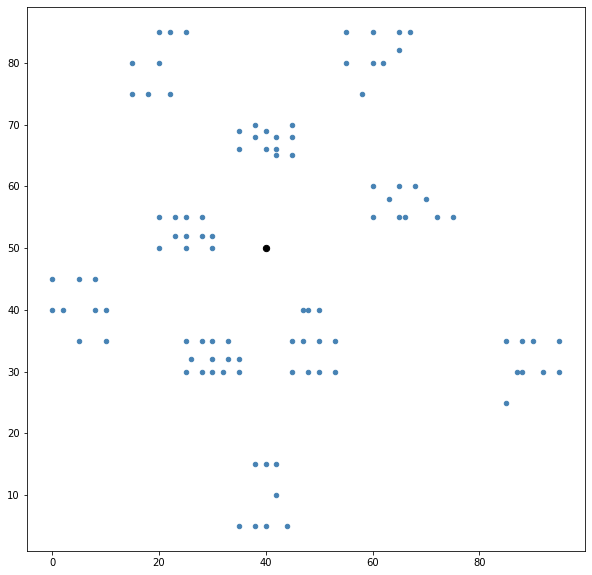

[acs_vehicle]: found a feasible path, send path info to macs
[macs]: receive found path info
[acs_vehicle]: receive global path info
**************************************************
[acs_vehicle]: new iteration
[macs]: distance of found path (1533.353376) better than best path's (1870.693800)
it takes 5.376 second from multiple_ant_colony_system running
**************************************************
**************************************************
[macs]: vehicle num of found path (12) better than best path's (21), found path distance is 1533.353376
it takes 5.725 second multiple_ant_colony_system running
**************************************************
[macs]: send stop info to acs_time and acs_vehicle
[acs_vehicle]: receive stop event
[multiple_ant_colony_system]: new iteration
[local_search_procedure]: local search finished
[local_search_procedure]: local search finished
[local_search_procedure]: local search finished
[local_search_procedure]: local search finished
[macs]:

In [ ]:
# from vrptw_base import VrptwGraph
# from multiple_ant_colony_system import MultipleAntColonySystem


if __name__ == '__main__':
    file_path = '/content/c101.txt'
    ants_num = 10
    beta = 2
    q0 = 0.1
    show_figure = True

    graph = VrptwGraph(file_path)
    macs = MultipleAntColonySystem(graph, ants_num=ants_num, beta=beta, q0=q0, whether_or_not_to_show_figure=show_figure)
    macs.run_multiple_ant_colony_system()